## Mount drive & imports

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
%cd 'drive/My Drive/MIR'

# import libraries
import os, sys, shutil
from pathlib import Path
import pandas as pd
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import matplotlib.pyplot as plt
import essentia.standard as ess
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')#suppress warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/MIR
     |████████████████████████████████| 11.7MB 342kB/s 


## Prepare English Dataset: 4Q-EMOTION (Go straight to "Load .csv files" if these are available)

In [ ]:
main_data_dir = 'MER_audio_taffc_dataset'
#Dictionary containing for each emotion class a list that carries dictionaries
inst_files = dict() 
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
      if file.endswith('mp3'):
        file_name = os.path.join(root,file)
        path = Path(file_name)
        parent=str(path.parent)
        emotion = parent.split(os.sep)[1]
        files_emotion = inst_files.get(emotion)
        if files_emotion == None:
          files_emotion = [file_name]
        else:
          files_emotion.append(file_name)
        inst_files[emotion] = files_emotion

## Prepare Chinese Dataset: CH-818 (Go straight to "Load .csv files" if these are available)

In [ ]:
# Read excel file with annotations of CH-818
data = pd.read_excel('CH818.xlsx')
labels = data['Quads'].tolist()

# Read all music files
path = 'ch818_mp3'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.mp3' in file:
            files.append(os.path.join(r, file))

# Dictionary containing for each emotion class a list that carries dictionaries
inst_files = dict() 
for i, file in enumerate(files):
    emotion = labels[i]
    files_emotion = inst_files.get(emotion)
    file_name = os.path.join(file)
    if files_emotion == None:
        files_emotion = [file_name]
    else:
        files_emotion.append(file_name)
    inst_files[emotion] = files_emotion

## Prepare Turkish Dataset: TR-MUSIC (Go straight to "Load .csv files" if these are available)

In [ ]:
main_data_dir = 'tr-music-dataset'
#Dictionary containing for each emotion class a list that carries dictionaries
inst_files = dict() 
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
      if file.endswith('mp3'):
        file_name = os.path.join(root,file)
        path = Path(file_name)
        parent=str(path.parent)
        emotion = parent.split(os.sep)[1]
        files_emotion = inst_files.get(emotion)
        if files_emotion == None:
          files_emotion = [file_name]
        else:
          files_emotion.append(file_name)
        inst_files[emotion] = files_emotion

## Pre-processing of data

Balancing


In [ ]:
# Balance data if neccessary (Chinese dataset)
#inst_files['Q1'] = inst_files['Q1'][:89]  
#inst_files['Q2'] = inst_files['Q2'][:89]  
#inst_files['Q3'] = inst_files['Q3'][:89]  

# Check data is balanced
for key in inst_files.keys():
    print(key, ': ', len(inst_files[key]), ' samples \n')

Train - test split

In [ ]:
# Put into X and y arrays.
X = []
y = []
for emotion, files in inst_files.items():
    for file in files:
        X.append(file)
        y.append(emotion)

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("Size of train set: ", len(X_train), ", Size of train output vector: ", len(y_train))
print("Size of test set: ", len(X_test), ", Size of test output vector: ", len(y_test))

Segmentation

In [ ]:
# Create segments
train_segments_dir = os.path.join(main_data_dir,'train_segments')
if not os.path.exists(train_segments_dir):#creating the directory
    os.mkdir(train_segments_dir)
test_segments_dir = os.path.join(main_data_dir,'test_segments')
if not os.path.exists(test_segments_dir):#creating the directory
    os.mkdir(test_segments_dir)

fs = 44100
file_count = 0
train_segment_files = []
test_segment_files = []
for i, file in enumerate(X):
    emotion = y[i]
    segments_dir = train_segments_dir if file in X_train else test_segments_dir
    x = ess.MonoLoader(filename = file, sampleRate = fs)()
    #Split song in 4 segments 
    split = (int)(len(x)/4)
    x_seg = [x[:split], x[split:2*split], x[2*split:3*split], x[3*split:]]
    for seg in x_seg:
        #Amplitude normalisation
        seg = seg / np.max(np.abs(seg))
        filename = os.path.join(segments_dir, emotion + '_' + str(file_count) + '.wav')
        ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(seg)
        file_count +=1
        train_segment_files.append(filename) if file in X_train else test_segment_files.append(filename)
print(len(train_segment_files),'segment files created')
print(len(test_segment_files),'segment files created')

## Features

Feature extraction

In [ ]:
#Running music extractor for a file
file = train_segment_files[0]#simply pick the first file in the list
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]

#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(train_segments_dir,'train_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in train_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)
# same for test set
data_file = os.path.join(test_segments_dir,'test_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in test_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)

Load .csv files

In [14]:
# Analysis of features   ---> Uncomment next lines if .csv already created
#train_file = 'MER_audio_taffc_dataset/train_segments/train_data.csv' 
#test_file = 'MER_audio_taffc_dataset/test_segments/test_data.csv'
#train_file = 'CH-818/train_segments/train_data.csv'
#test_file = 'CH-818/test_segments/test_data.csv' 
train_file = 'tr-music-dataset/train_segments/train_data.csv' 
test_file = 'tr-music-dataset/test_segments/test_data.csv'

#Read data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
print("Data is null:")
print(train_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan
print(test_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan

Data is null:
0
0


Normalize features

In [15]:
# Normalization of features
train_data_modif = train_data.copy()
test_data_modif = test_data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
min_max_scaler = preprocessing.MinMaxScaler()
train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(train_data.iloc[:,:84].values)
test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(test_data.iloc[:,:84].values)

Re-balance train set

In [16]:
train_data_modif.emotion.value_counts()

q3    328
q1    328
q4    328
q2    296
Name: emotion, dtype: int64

In [17]:
# Balancing data  ---> adapt this to the numbers above
data_modif = train_data_modif
min_number = data_modif.emotion.value_counts()['q2']
q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)

#Merging after downsampling
train_data_modif = pd.concat([q1_data, q2_data, q3_data, q4_data])
#Checking the balance again
train_data_modif.emotion.value_counts()

q3    296
q1    296
q2    296
q4    296
Name: emotion, dtype: int64

Feature selection

In [18]:
# Preparing data arrays for features and labels
#input values put in a matrix, there are 84 features
X_train = train_data_modif.iloc[:,:84].values 
X_test = test_data_modif.iloc[:,:84].values 
#Creating output values
train_data_modif.emotion = pd.Categorical(train_data_modif.emotion)#convert to categorical data
test_data_modif.emotion = pd.Categorical(test_data_modif.emotion)#convert to categorical data
y_train = np.array(train_data_modif.emotion.cat.codes) #create label encoded outputs
y_test = np.array(test_data_modif.emotion.cat.codes) #create label encoded outputs

# Feature selection
z = SelectKBest(chi2, k=50)
fit = z.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 

X_train = fit.transform(X_train)
X_test = fit.transform(X_test)   # only consider selected features from the training set
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape, '\n')

print('Top 10 selected features: ')
for i in ten:
    print(train_data_modif.keys()[i])

X_train shape is  (1184, 50)
X_test shape is  (320, 50) 

Top 10 selected features: 
silence_rate_30dB.stdev
spectral_centroid.mean
spectral_skewness.stdev
melbands_spread.mean
spectral_kurtosis.stdev
silence_rate_60dB.stdev
barkbands_spread.mean
zerocrossingrate.mean
barkbands_flatness_db.mean
spectral_kurtosis.mean


## Machine Learning

Comparison of classifiers

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    RandomForestClassifier(max_depth=15, random_state=0)]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes", "Random Forest"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train_val)
    norm_x_train = scaler.transform(x_train_val)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train_val)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))

KNN: acc = 0.80, +-0.05,	values: [0.82 0.82 0.75 0.78 0.72 0.78 0.75 0.87 0.85 0.83]
Linear SVM: acc = 0.81, +-0.03,	values: [0.85 0.79 0.77 0.81 0.75 0.8  0.85 0.82 0.82 0.84]
RBF SVM: acc = 0.71, +-0.06,	values: [0.8  0.73 0.62 0.61 0.73 0.76 0.68 0.79 0.64 0.74]
Gaussian Process: acc = 0.89, +-0.02,	values: [0.9  0.86 0.87 0.87 0.88 0.89 0.87 0.94 0.89 0.92]
Neural Net: acc = 0.89, +-0.04,	values: [0.9  0.86 0.82 0.87 0.87 0.87 0.92 0.94 0.88 0.93]
Naive Bayes: acc = 0.68, +-0.03,	values: [0.7  0.63 0.66 0.68 0.66 0.63 0.68 0.7  0.68 0.74]
Random Forest: acc = 0.84, +-0.03,	values: [0.86 0.82 0.8  0.84 0.83 0.83 0.79 0.86 0.87 0.89]


Multi-layer perceptron

Number of test samples:  320
              precision    recall  f1-score   support

           0       0.66      0.81      0.73        72
           1       0.78      0.69      0.73       104
           2       0.64      0.35      0.45        72
           3       0.54      0.76      0.64        72

    accuracy                           0.66       320
   macro avg       0.66      0.65      0.64       320
weighted avg       0.67      0.66      0.65       320

Confusion matrix: 



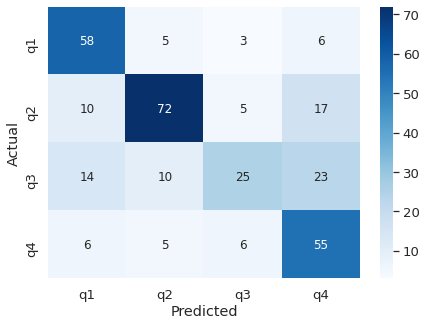

In [19]:
selected_model = RandomForestClassifier(max_depth=15, random_state=0) # MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");